# Prey-Predator simulation in cadCAD

*Danilo Lessa Bernardineli* 

---

This is an cadCAD simulation of the Lotka-Volterra prey-predator model. This is a minimal example contained inside a notebook, and it can be used for quick experimentations

## Dependences

In [ ]:
import sys
sys.path.insert(1, '..')
from cadcad_machine_search.tools import sweep_cartesian_product


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

## Definitions

### Initial conditions and parameters

In [ ]:
initial_conditions = {
    'prey_population': 100,
    'predator_population': 15
    }

sweep_params = {    
    "predator_death_const": np.linspace(0.9, 1.1, 4),
    "prey_death_const": np.linspace(0.02, 0.04, 4),
    "dt": np.linspace(0.04, 0.06, 4)
    }

params = {
    "prey_birth_rate": [1.0],
    "predator_birth_rate": [0.01],
    **sweep_cartesian_product(sweep_params)

}

simulation_parameters = {
    'N': 2,
    'T': range(10),
    'M': params
}

### Policies

In [ ]:
def p_predator_births(params, step, sL, s):
  dt = params['dt']
  predator_population = s['predator_population']
  prey_population = s['prey_population']
  birth_fraction = params['predator_birth_rate'] + np.random.random() * 0.0002
  births =  birth_fraction * prey_population * predator_population * dt
  return {'add_to_predator_population': births}


def p_prey_births(params, step, sL, s):
  dt = params['dt']
  population = s['prey_population']
  birth_fraction = params['prey_birth_rate'] + np.random.random() * 0.1
  births =  birth_fraction * population * dt
  return {'add_to_prey_population': births}


def p_predator_deaths(params, step, sL, s):
  dt = params['dt']
  population = s['predator_population']
  death_rate = params['predator_death_const'] + np.random.random() * 0.005
  deaths = death_rate * population * dt
  return {'add_to_predator_population': -1.0 * deaths}


def p_prey_deaths(params, step, sL, s):
  dt = params['dt']
  death_rate = params['prey_death_const'] + np.random.random() * 0.1
  prey_population = s['prey_population']
  predator_population = s['predator_population']
  deaths = death_rate * prey_population * predator_population * dt
  return {'add_to_prey_population': -1.0 * deaths}

### State update functions

In [ ]:
def s_prey_population(params, step, sL, s, _input):
    y = 'prey_population'
    x = s['prey_population'] + _input['add_to_prey_population']
    return (y, x)


def s_predator_population(params, step, sL, s, _input):
    y = 'predator_population'
    x = s['predator_population'] + _input['add_to_predator_population']
    return (y, x)

### State update blocks

In [ ]:
partial_state_update_blocks = [
    { 
        'policies': {
            'predator_births': p_predator_births,
            'prey_births': p_prey_births,
            'predator_deaths': p_predator_deaths,
            'prey_deaths': p_prey_deaths,
        },
        'variables': {
            'predator_population': s_prey_population,
            'prey_population': s_predator_population
        }
    }
]

### Configuration and Execution

In [7]:
sim_config = config_sim(simulation_parameters)

exp = Experiment()
exp.append_configs(sim_configs=sim_config, 
                   initial_state=initial_conditions,
                   partial_state_update_blocks=partial_state_update_blocks)


from cadCAD import configs
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.local_mode)
executor = Executor(exec_context=exec_context, configs=exp.configs) 
(records, tensor_field, _) = executor.execute() 

Total execution time: 97.47s


### Results

In [8]:
df = pd.DataFrame(records)

# Drop all intermediate substeps
first_ind = (df.substep == 0) & (df.timestep == 0)
last_ind = df.substep == max(df.substep)
inds_to_drop = (first_ind | last_ind)
df = df.loc[inds_to_drop].drop(columns=['substep'])
# Attribute parameters to each row
configs=exp.configs
df = df.assign(**configs[0].sim_config['M'])
for i, (_, n_df) in enumerate(df.groupby(['simulation', 'subset', 'run'])):
    df.loc[n_df.index] = n_df.assign(**configs[i].sim_config['M'])

      prey_population  predator_population  simulation  subset  run  timestep  \
0          100.000000            15.000000           0       0    1         0   
1           97.518146            15.069196           0       0    1         1   
2           95.504542            15.117710           0       0    1         2   
3           98.281937            15.157920           0       0    1         3   
4           97.892181            15.212674           0       0    1         4   
...               ...                  ...         ...     ...  ...       ...   
1403        91.066502            14.134879           0      63    2         6   
1404        88.217101            13.974729           0      63    2         7   
1405        87.854816            13.794260           0      63    2         8   
1406        88.016315            13.615681           0      63    2         9   
1407        84.125838            13.446159           0      63    2        10   

      prey_birth_rate  pred

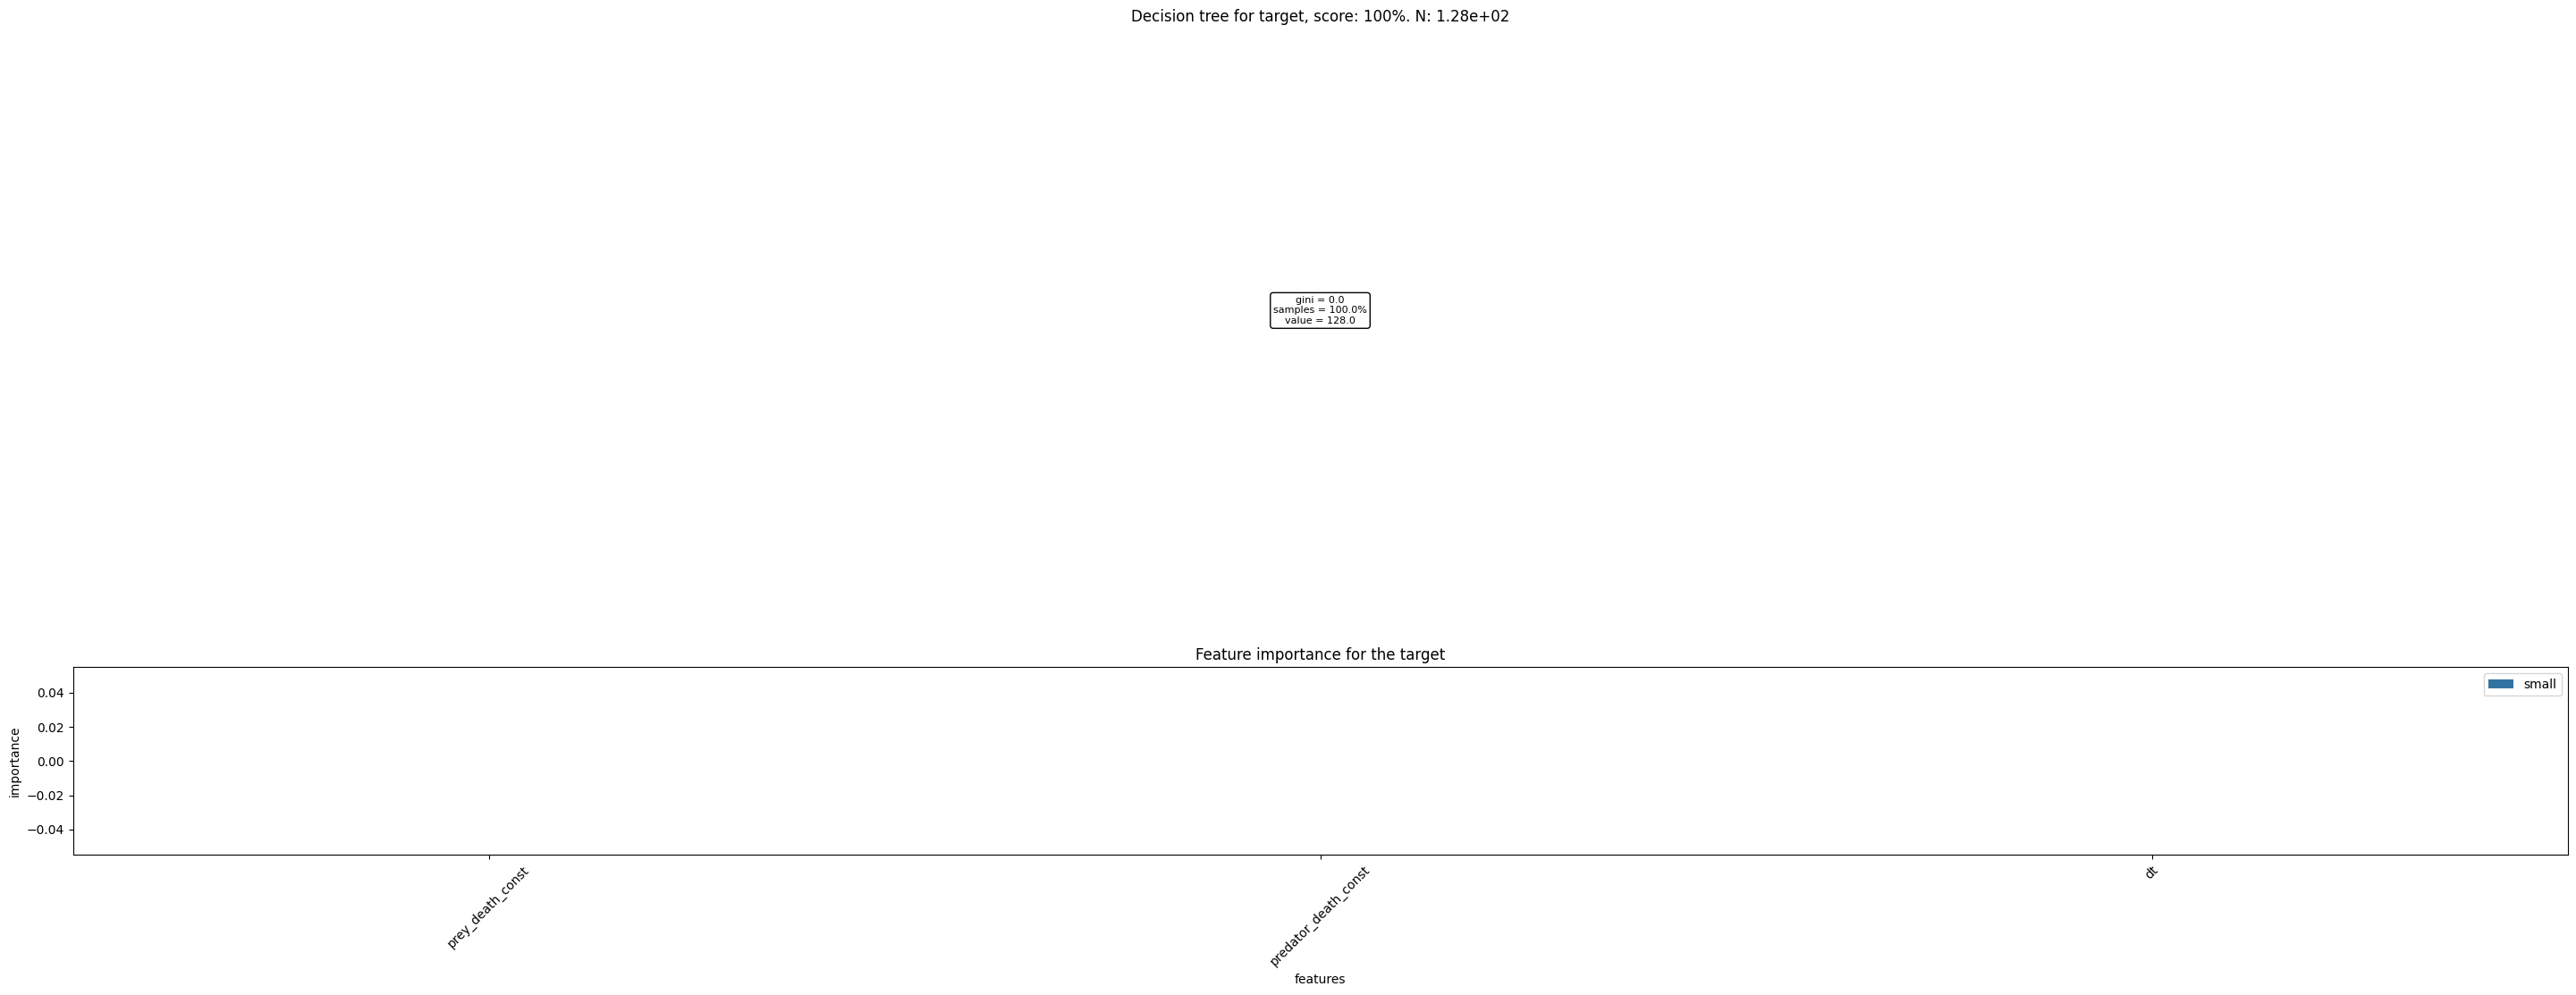

In [9]:
from cadcad_machine_search.visualizations import kpi_sensitivity_plot

print(df)
# KPI: prey population is 5x above the predator populaton at least 90% of the time
control_params = list(set(sweep_params.keys()))
print(control_params)
WEIGHT = 5.0
kpi = lambda df: (df.prey_population > WEIGHT * df.predator_population).mean() > 0.9
kpi_sensitivity_plot(df, kpi, control_params)


In [10]:
from cadcad_machine_search.visualizations import plot_goal_ternary

control_params = list(set(sweep_params.keys()))

PREY_ABUNDANCE_THRESHOLD = (df.prey_population / df.predator_population).mean()
PREDATOR_ABUNDANCE_THRESHOLD = (df.predator_population / df.prey_population).mean()
PREY_VARIANCE_THRESHOLD = df.prey_population.std()
PREDATOR_VARIANCE_THRESHOLD = df.predator_population.std()

kpis = {'prey_abundance': lambda df: df.prey_population.mean(),
        'predator_abundance': lambda df: df.predator_population.mean(),
        'prey_variance': lambda df: 1 / df.prey_population.std(),
        'predator_variance': lambda df: 1 / df.predator_population.std(),
        }

# Define goals as sides of the triangle
goals = {}
goals['Prey Desirability'] = lambda metrics: (metrics['prey_abundance'] + metrics['prey_variance']) / 2
goals['Predator Desirability'] = lambda metrics: (metrics['predator_abundance'] + metrics['predator_variance']) / 2
goals['System Stability'] = lambda metrics: (metrics['prey_variance'] + metrics['predator_variance']) / 2
goals['combined'] = lambda goals: goals[0] + goals[1] + goals[2]

plot_goal_ternary(df, kpis, goals, control_params)

In [11]:
df

,prey_population,predator_population,simulation,subset,run,timestep,prey_birth_rate,predator_birth_rate,predator_death_const,prey_death_const,dt
0,100.000000,15.000000,0,0,1,0,1.0,0.01,0.9,0.02,0.04
1,97.518146,15.069196,0,0,1,1,1.0,0.01,0.9,0.02,0.04
2,95.504542,15.117710,0,0,1,2,1.0,0.01,0.9,0.02,0.04
3,98.281937,15.157920,0,0,1,3,1.0,0.01,0.9,0.02,0.04
4,97.892181,15.212674,0,0,1,4,1.0,0.01,0.9,0.02,0.04
...,...,...,...,...,...,...,...,...,...,...,...
1403,91.066502,14.134879,0,63,2,6,1.0,0.01,1.1,0.04,0.06
1404,88.217101,13.974729,0,63,2,7,1.0,0.01,1.1,0.04,0.06
1405,87.854816,13.794260,0,63,2,8,1.0,0.01,1.1,0.04,0.06
1406,88.016315,13.615681,0,63,2,9,1.0,0.01,1.1,0.04,0.06


In [12]:
df2 = pd.DataFrame(records)